In [1]:
from pathlib import Path
notebook_path = Path().cwd().parent.parent.parent.parent
import sys; sys.path.insert(0, str(notebook_path))

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import warnings

# custom functions
from explore.gcp.storage import gcp
from explore.src.utilities.eda_funcs import describe_data
from explore.src.visualisation.valuations_visual import PlayerValsPlots
from explore.src.preprocess.clean_valuations import CleanPlayerVals

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [2]:
# read in la liga data
df = gcp.read_df_from_bucket(bucket_name='processed_transfermarkt_db', blob_name='processed_la_liga_player_valuations.csv')

[03/21/24 18:16:43] INFO     explore.gcp.storage - [ MainThread:get_gcp_bucket:28 ] - Getting GCP bucket                                 ]8;id=612872;file:///Users/conal/Projects/fpl_app/exploration/explore/gcp/storage.py\storage.py]8;;\:]8;id=849429;file:///Users/conal/Projects/fpl_app/exploration/explore/gcp/storage.py#28\28]8;;\

[03/21/24 18:16:44] INFO     explore.gcp.storage - [ MainThread:get_gcp_bucket:33 ] - GCP bucket retrieved                               ]8;id=535733;file:///Users/conal/Projects/fpl_app/exploration/explore/gcp/storage.py\storage.py]8;;\:]8;id=689016;file:///Users/conal/Projects/fpl_app/exploration/explore/gcp/storage.py#33\33]8;;\

In [3]:
df.head()

,tm_id,tm_name,player,squad_num,position,age,country,current_club,height,foot,signed_date,signed_from,signing_fee_euro_mill,contract_expiry,market_value_euro_mill,season,league,team,signed_year,player_id
0,74857,marc-andre-ter-stegen,Marc-André ter Stegen,1,Goalkeeper,26,Germany,FC Barcelona,187.0,right,"Jul 1, 2014",Borussia Mönchengladbach,12.0,NaN,60.0,2017,la_liga,fc-barcelona,2014.0,2325.0
1,146227,jasper-cillessen,Jasper Cillessen,13,Goalkeeper,29,Netherlands,NEC Nijmegen,187.0,right,"Aug 25, 2016",Ajax Amsterdam,13.0,NaN,9.0,2017,la_liga,fc-barcelona,2016.0,489.0
2,142033,adrian-ortola,Adrián Ortolá,31,Goalkeeper,24,Spain,CE Sabadell FC,187.0,left,"Jul 1, 2018",FC Barcelona B,NaN,NaN,1.5,2017,la_liga,fc-barcelona,2018.0,NaN
3,126540,samuel-umtiti,Samuel Umtiti,23,Centre-Back,24,France,LOSC Lille,182.0,left,"Jul 14, 2016",Olympique Lyon,25.0,NaN,60.0,2017,la_liga,fc-barcelona,2016.0,2395.0
4,18944,gerard-pique,Gerard Piqué,3,Centre-Back,31,Spain,Retired,194.0,right,"Jul 1, 2008",Manchester United,5.0,NaN,50.0,2017,la_liga,fc-barcelona,2008.0,1883.0


In [4]:
# investigate data
describe_data(df)

,Data Types,Null Counts,Null %,Unique Values,Min,Max,Median,Mean,Std Dev,Outliers,Outliers %
tm_id,int64,0,0.00,1939,5856.0,1064499.0,263627.00,306006.27,218643.18,63,1.31
squad_num,int64,0,0.00,56,0.0,57.0,14.00,14.61,11.23,12,0.25
age,int64,0,0.00,28,15.0,42.0,26.00,25.95,4.69,0,0.00
height,float64,0,0.00,41,18.0,203.0,182.00,181.31,6.86,18,0.37
signing_fee_euro_mill,float64,1416,29.35,167,0.0,135.0,0.75,6.01,14.72,444,9.20
market_value_euro_mill,float64,221,4.58,105,0.1,180.0,2.50,8.12,14.93,558,11.56
season,int64,0,0.00,7,2017.0,2023.0,2020.00,2019.94,1.92,0,0.00
signed_year,float64,655,13.58,22,2002.0,2024.0,2019.00,2018.55,3.05,83,1.72
player_id,float64,1278,26.49,1210,5.0,6305.0,2190.00,2422.19,1595.10,0,0.00


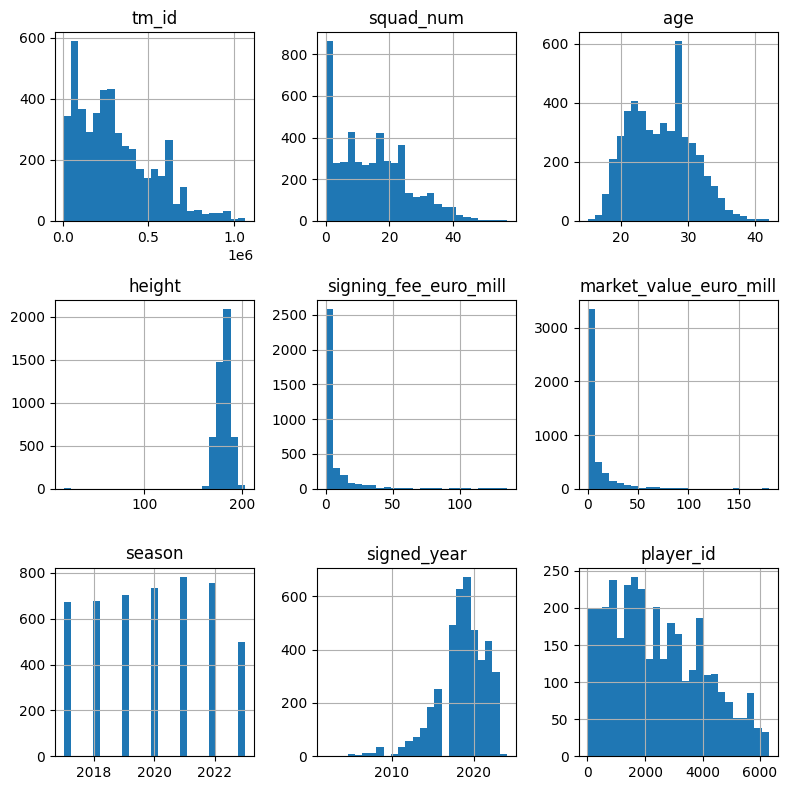

In [5]:
# plot distributions of the data
df.hist(bins=25, figsize=(8,8))
plt.tight_layout()
plt.show()

In [7]:
# initialise plotter
plots = PlayerValsPlots(df)

## Position Analysis

In [8]:
plots.valuation_plot('position')

## Country Analysis

In [9]:
plots.valuation_plot('country')

In [10]:
# plot total players for each season by country - timeseries
plots.var_totals_plot('country')

## Team Analysis

In [11]:
plots.valuation_plot('team')

In [12]:
# for each season, get the average difference between signing fee and market value for the players that were signed by team
dfs = []
for year in df["season"].unique():
    dff = df.loc[(df["season"] == year) & (df["signed_year"] == year)]
    dff.loc[:, "diff_sign_fee_mv"] = (
        dff["market_value_euro_mill"] - dff["signing_fee_euro_mill"]
    )
    dfff = (
        dff.groupby("team")["diff_sign_fee_mv"]
        .mean()
        .sort_values(ascending=False)
        .reset_index()
    )
    dfff.loc[:, "season"] = year
    dfs.append(dfff)

df_diff_sign_fee_mv = pd.concat(dfs)

df_diff_sign_fee_mv.head()

,team,diff_sign_fee_mv,season
0,fc-valencia,4.666667,2017
1,real-sociedad-san-sebastian,4.333333,2017
2,celta-vigo,3.760000,2017
3,ud-las-palmas,2.200000,2017
4,fc-girona,2.100000,2017


In [13]:
px.line(
    df_diff_sign_fee_mv,
    x="season",
    y="diff_sign_fee_mv",
    color="team",
    title="Average difference between signing fee and market value over time",
)

## Signing Value Analysis

In [14]:
plots.plot_diff_val_paid(column='team')

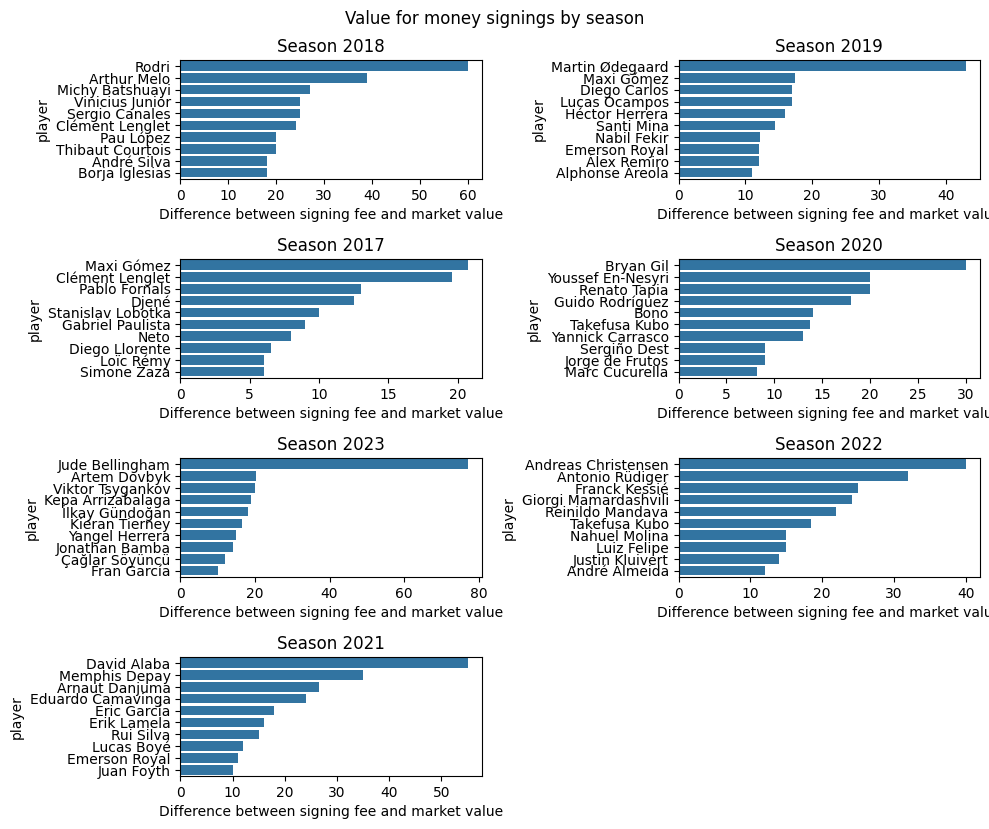

In [15]:
plots.plot_value_signings()

## Height Analysis

In [16]:
df['height'].isnull().sum(), (df['height'] == 0).sum()

(0, 0)

In [17]:
df['height'].value_counts().tail()

height
164.0    2
203.0    1
198.0    1
18.0     1
199.0    1
Name: count, dtype: int64

In [18]:
# one value with 18cm - impute with median
df.loc[df['height'] == 18, 'height'] = df['height'].median()

In [19]:
plots.valuation_plot('height')

- 200cm value likely skewed by Courtois

## Foot Analysis

In [20]:
plots.valuation_plot('foot')

## Age Analysis

In [21]:
plots.valuation_plot('age')

- 16 year old market value likely dominated by Yamal

In [22]:
plots.plot_diff_val_paid('age')